# 6.4 컨브넷을 사용한 시퀀스 처리
- 시간을 2D 이미지의 높이와 너비 같은 공간의 차원으로 다루기
- **1D 컨브넷**(1D Convnet) : 특정 시퀀스 처리 문제에서 RNN과 성능은 비등하며 비용이 훨씬 쌈
- 팽창된 커널(dilated kernel)과 함께 사용(커널에 구멍을 추가하여 입력을 건너뛰면서 합성곱하는 것과 같음)
- 오디오 생성과 기계 번역 등에서 큰 성과

## 6.4.1 시퀀스 데이터를 위한 1D 합성곱 이해하기
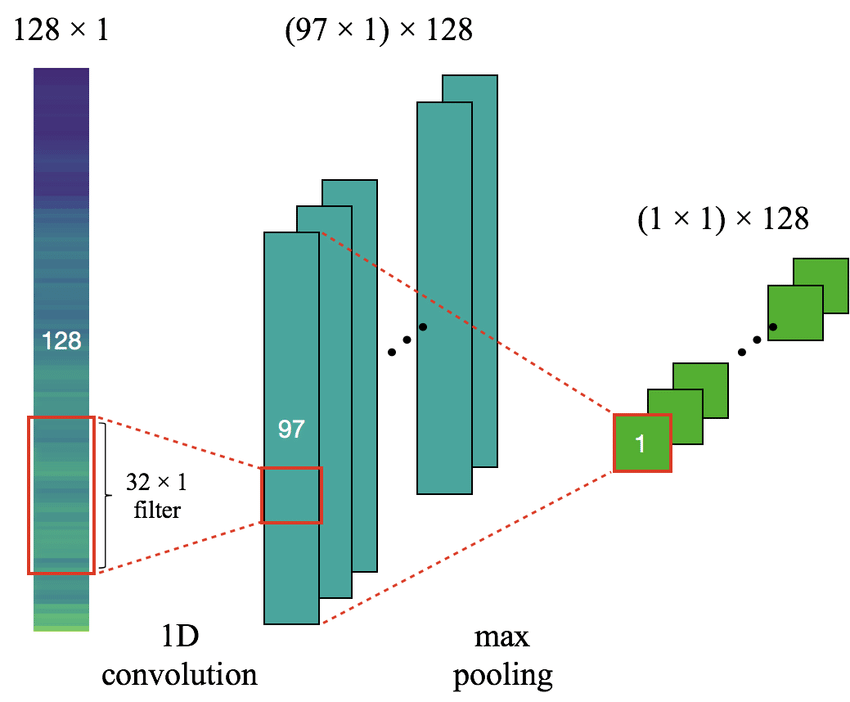
출처 : https://www.researchgate.net/figure/1D-ConvNet-structure-for-frame-wise-feature-extraction-The-output-feature-size-is-same_fig2_325465154

- 입력 시퀀스에서 시간 축으로 패치를 추출하여 출력 타임스텝을 만듦
- 시퀀스에 있는 지역 패턴을 인식
    - 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 내용을 다른 위치에서 인식할 수 있음
    - 시간의 이동에 대한 이동 불변성(translation invariant)을 제공
    - 문자 수준의 1D 컨브넷은 단어 형태학(word morphology)에 관해 학습할 수 있음

## 6.4.2 시퀀스 데이터를 위한 1D 풀링
- 최댓값(최대 풀링)이나 평균값(평균 풀링) 출력
- **서브샘플링**을 위해 사용(1D 입력의 길이를 줄이기 위해)

## 6.4.3 1D 컨브넷 구현
- `Conv1D` 층을 사용
    - `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환
    - 합성곱 윈도우는 시간 축의 1D 윈도우(입력 텐서의 두 번째 축)

### IMDB 데이터 전처리하기

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('데이터 로드 ...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기 :', x_train.shape)
print('x_test 크기 :', x_test.shape)

데이터 로드 ...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기 : (25000, 500)
x_test 크기 : (25000, 500)


### IMDB 데이터에 1D 컨브넷을 훈련하고 평가하기
- 1D 컨브넷은 2D 컨브넷과 비슷한 방식으로 구성
    - `Conv1D`와 `MaxPooling1D` 층을 쌓고 **전역 풀링 층**이나 `Flatten` 층으로 마침
    - 전역 풀링 층 : `GlobalAveragePooling1D` 또는 `GlobalMaxPooling1D` 풀링은 시간 축 전체에 풀링을 적용하여 `(samples, features)` 크기의 텐서를 출력하며 `GlobalAveragePooling2D` 또는 `GlobalMaxPooling2D`는 특성 맵의 공간 차원 전체에 대한 풀링으로 `(samples, channels)` 크기의 텐서를 출력
    - 2D 합성곱 윈도우가 3x3으로 총 9개의 특성을 고려했다면 1D 합성곱 윈도우 크기가 3은 3개의 특성만 고려 > 1D 합성곱의 크기는 7이나 9 정도를 사용

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

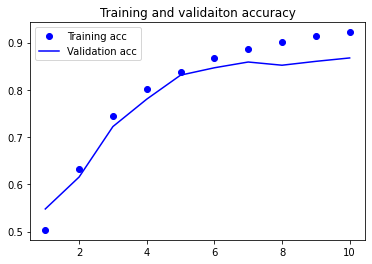

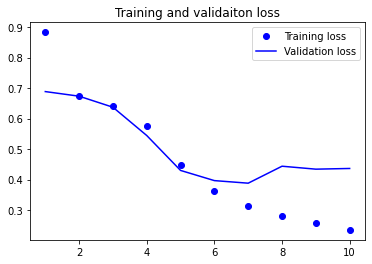

In [3]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validaiton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validaiton loss')
plt.legend()

plt.show()

- `LSTM`보다 검증 정확도는 낮지만(0.88 > 0.86) 속도는 빠름 (epoch 당 3초 > 2초)
- 적절한 에포크 수(7개)로 모델을 다시 훈련하고 테스트 세트에서 확인

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=7, batch_size=128,
                    validation_split=0.2)

print('\n테스트 세트로 확인')
model.evaluate(x_test, y_test)

Epoch 1/7
157/157 [==============================] - 2s 12ms/step - loss: 0.7316 - accuracy: 0.5337 - val_loss: 0.6814 - val_accuracy: 0.6130
Epoch 2/7
157/157 [==============================] - 2s 11ms/step - loss: 0.6585 - accuracy: 0.7042 - val_loss: 0.6524 - val_accuracy: 0.6964
Epoch 3/7
157/157 [==============================] - 2s 11ms/step - loss: 0.6009 - accuracy: 0.7768 - val_loss: 0.5763 - val_accuracy: 0.7730
Epoch 4/7
157/157 [==============================] - 2s 11ms/step - loss: 0.4828 - accuracy: 0.8224 - val_loss: 0.4557 - val_accuracy: 0.8144
Epoch 5/7
157/157 [==============================] - 2s 11ms/step - loss: 0.3825 - accuracy: 0.8595 - val_loss: 0.4116 - val_accuracy: 0.8414
Epoch 6/7
157/157 [==============================] - 2s 11ms/step - loss: 0.3269 - accuracy: 0.8831 - val_loss: 0.4028 - val_accuracy: 0.8528
Epoch 7/7
157/157 [==============================] - 2s 11ms/step - loss: 0.2921 - accuracy: 0.8989 - val_loss: 0.4039 - val_accuracy: 0.8628

테스트 세

[0.4251800775527954, 0.856719970703125]

## 6.4.4 CNN과 RNN을 연결하여 긴 시퀀스를 처리하기
- 1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 타임스텝의 순서에 민감하지 않음
- 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있음
- 그러나 순서를 감지하기에는 부족

### 예나 데이터 불러오기

In [5]:
import os

data_dir = '../datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''
    data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
    lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    delay : 타깃으로 사용할 미래의 타임스텝
    min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
    shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
    batch_size : 배치의 샘플 수
    step : 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
lookback = 1440 # 특정 날짜로부터 10일만큼 전 데이터를 사용
step = 6 # 10일치 데이터 중 1시간 간격 데이터를 사용
delay = 144 # 특정 날짜로부터 1시간 뒤 데이터를 타겟으로 사용
batch_size = 128

# 처음 20만개 데이터를 훈련 데이터로 사용
train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)

# 그 다음 10만개 데이터를 검증용 데이터로 사용
val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, shuffle=True,
                    step=step, batch_size=batch_size)

# 나머지를 테스트 데이터로 사용
test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None, shuffle=True,
                     step=step, batch_size=batch_size)

# generator 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려 주어야 함
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 예나 데이터에서 1D 컨브넷을 훈련하고 평가하기

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [12]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 20ms/step - loss: 0.4131 - val_loss: 0.4393
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3580 - val_loss: 0.4408
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3313 - val_loss: 0.4679
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3149 - val_loss: 0.4508
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3041 - val_loss: 0.4514
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2968 - val_loss: 0.4477
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2876 - val_loss: 0.4621
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2823 - val_loss: 0.4431
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2738 - val_loss: 0.4460
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.269

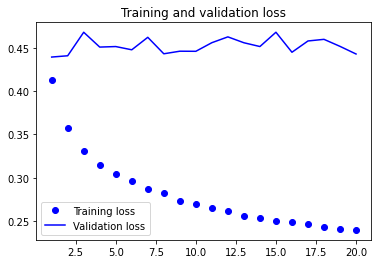

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 검증 MAE가 0.40대에 머물러 있음 : 입력 시계열의 패턴을 보고 이 패턴이 시간 축의 위치(시작인지 끝 부분인지 등)를 고려하지 않기 때문
- 컨브넷의 속도와 RNN의 순서 감지를 결합하는 방식 : 1D 컨브넷을 RNN 이전 전처리 단계로 사용
    - 특히나 긴 시퀀스를 다룰 때 도움이 됨

긴 시퀀스 → 1D CNN → 짧은 시퀀스(CNN 특성) → RNN

### 고밀도 데이터 제너레이터로 예나 데이터셋 준비하기
- 긴 시퀀스를 다룰 수 있으므로 더 오래 전 데이터를 바라보거나(`lookback` 매개변수를 증가) 시계열 데이터를 더 촘촘히 사용(`step` 매개변수 감소)
- 여기서는 `step`을 절반으로 줄여서 사용

In [14]:
step = 3 # 30분마다 1 포인트
# 변경되지 않은 매개변수
lookback = 1440
delay = 144

# 처음 20만개 데이터를 훈련 데이터로 사용
train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step)

# 그 다음 10만개 데이터를 검증용 데이터로 사용
val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, shuffle=True,
                    step=step)

# 나머지를 테스트 데이터로 사용
test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None, shuffle=True,
                     step=step)

# generator 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려 주어야 함
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // 128

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // 128

### 1D 합성곱과 GRU 층을 연결한 모델
- `GRU` 층만 사용했을 때보다 학습 시간 감소(에포크당 약 560초 > 420초) : `Conv1D`와 `MaxPooling1D` 층으로 데이터를 줄였기 때문

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [16]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=RMSprop(), loss='mae')

In [18]:
%%time

history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 427s 851ms/step - loss: 0.3310 - val_loss: 0.2893
Epoch 2/20
500/500 [==============================] - 420s 840ms/step - loss: 0.2931 - val_loss: 0.2760
Epoch 3/20
500/500 [==============================] - 420s 840ms/step - loss: 0.2810 - val_loss: 0.2791
Epoch 4/20
500/500 [==============================] - 423s 847ms/step - loss: 0.2718 - val_loss: 0.2762
Epoch 5/20
500/500 [==============================] - 422s 845ms/step - loss: 0.2640 - val_loss: 0.2768
Epoch 6/20
500/500 [==============================] - 422s 844ms/step - loss: 0.2573 - val_loss: 0.2794
Epoch 7/20
500/500 [==============================] - 421s 843ms/step - loss: 0.2497 - val_loss: 0.2883
Epoch 8/20
500/500 [==============================] - 422s 845ms/step - loss: 0.2458 - val_loss: 0.2846
Epoch 9/20
500/500 [==============================] - 422s 843ms/step - loss: 0.2412 - val_loss: 0.2909
Epoch 10/20
500/500 [==============================] - 420s 841m

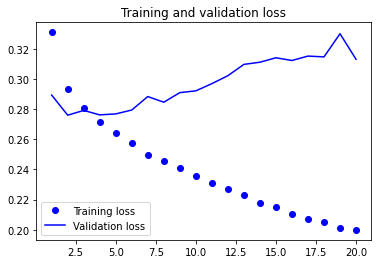

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 검증 손실로 비교해 보면 규제가 있는 `GRU` 모델만큼 좋지는 않지만 훨씬 빠르기 때문에 그만큼 더 많은 데이터를 처리할 수 있음
- 이번 데이터셋에는 도움이 되지 않았지만 다른 데이터셋에는 도움이 될 수 있음